# Importing Dependencies

In [1]:
!pip install opencv-python mediapipe sklearn matplotlib

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing = mp.solutions.drawing_utils # Drawing Utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Conversion BGR -> RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make Prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color Conversion RGB -> BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw Face Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw Pose Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw Left Hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw Right Hand Connections

In [6]:
def draw_styled_landmarks(image, results):
     # Draw Face Connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1, circle_radius=1))
    
    # Draw Pose Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121),thickness=2, circle_radius=2))
    
    # Draw Left Hand Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250),thickness=2, circle_radius=2)) 
    
    # Draw Right Hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)) 

In [7]:
mp_holistic.HAND_CONNECTIONS

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})

In [62]:
# Starting Camera
cap = cv2.VideoCapture(0)
# Access Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read Feed
        ret, frame = cap.read()

        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw Landmarks
        draw_styled_landmarks(image, results)

        # Show to Screen
        cv2.imshow('OpenCV Feed', image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
len(results.pose_landmarks.landmark)

33

In [10]:
draw_landmarks(frame,results)

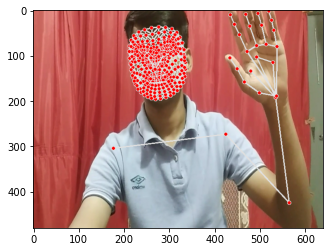

In [11]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

# Extracting Keypoint Values

In [12]:
len(results.face_landmarks.landmark)

468

In [13]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [14]:
# flatten() combines everything into one big array
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
result_test = extract_keypoints(results)

In [17]:
result_test

array([ 0.42163974,  0.27126116, -0.71200091, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
np.save('0',result_test)

# Setup Folders for Collection

In [19]:
# Path for the exported Data (numpy arrays)
DATA_PATH = os.path.join('MP_Data')

# Actions to be Detected
actions = np.array(['Hello','Thanks', 'Peace'])

# 30 Videos worth of Data
no_sequences = 30

# Videos are going to be 30 frames in Length
sequence_length = 30

In [20]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for testing and Training

In [21]:
# Starting Camera
cap = cv2.VideoCapture(0)
# Access Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        
        # Loop through sequences (videos)
        for sequence in range(no_sequences):
            # Loop through video length (sequence length)
            for frame_num in range(sequence_length):

                # Read Feed
                ret, frame = cap.read()

                # Make Detections
                image, results = mediapipe_detection(frame, holistic)
                
                # Draw Landmarks
                draw_styled_landmarks(image, results)
                
                # Apply Wait Logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting Frames for "{}" Video Number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to Screen
                    cv2.imshow('OpenCV Feed',image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting Frames for {} Video Number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to Screen
                    cv2.imshow('OpenCV Feed',image)

                # Export Keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
            

                # Break Gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

# Pre-Process Data , Create Labels and Features

In [22]:
# train_test_split allows to partition data in two parts: training and testing.
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical # to_categorical converts data into one hot encoded data.

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'Hello': 0, 'Thanks': 1, 'Peace': 2}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [26]:
np.array(sequences).shape

(90, 30, 1662)

In [27]:
np.array(labels).shape

(90,)

In [28]:
X = np.array(sequences)

In [29]:
X.shape

(90, 30, 1662)

In [30]:
y = to_categorical(labels).astype(int)

In [31]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [33]:
X_train.shape

(85, 30, 1662)

# Building and Training LSTM Neural Network

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [35]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [36]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [37]:
X.shape

(90, 30, 1662)

In [38]:
res = [.7, 0.2, 0.1]

In [39]:
actions[np.argmax(res)]

'Hello'

In [40]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [41]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 8s 765ms/step - loss: 1.5963 - categorical_accuracy: 0.2824
Epoch 2/200
3/3 [==============================] - 1s 420ms/step - loss: 3.0685 - categorical_accuracy: 0.3176
Epoch 3/200
3/3 [==============================] - 1s 385ms/step - loss: 2.5045 - categorical_accuracy: 0.2588
Epoch 4/200
3/3 [==============================] - 1s 391ms/step - loss: 1.1094 - categorical_accuracy: 0.3059
Epoch 5/200
3/3 [==============================] - 1s 389ms/step - loss: 1.0149 - categorical_accuracy: 0.4471
Epoch 6/200
3/3 [==============================] - 1s 383ms/step - loss: 1.0723 - categorical_accuracy: 0.5176
Epoch 7/200
3/3 [==============================] - 1s 392ms/step - loss: 1.0967 - categorical_accuracy: 0.3412
Epoch 8/200
3/3 [==============================] - 1s 377ms/step - loss: 1.0660 - categorical_accuracy: 0.4000
Epoch 9/200
3/3 [==============================] - 1s 402ms/step - loss: 1.0401 - categorical_accuracy: 0.6000
E

3/3 [==============================] - 1s 386ms/step - loss: 0.8705 - categorical_accuracy: 0.4941
Epoch 75/200
3/3 [==============================] - 1s 393ms/step - loss: 1.1436 - categorical_accuracy: 0.3176
Epoch 76/200
3/3 [==============================] - 1s 373ms/step - loss: 1.1204 - categorical_accuracy: 0.3176
Epoch 77/200
3/3 [==============================] - 1s 398ms/step - loss: 1.1188 - categorical_accuracy: 0.3176
Epoch 78/200
3/3 [==============================] - 1s 421ms/step - loss: 1.1173 - categorical_accuracy: 0.3176
Epoch 79/200
3/3 [==============================] - 1s 405ms/step - loss: 1.1160 - categorical_accuracy: 0.3176
Epoch 80/200
3/3 [==============================] - 1s 378ms/step - loss: 1.1141 - categorical_accuracy: 0.3176
Epoch 81/200
3/3 [==============================] - 1s 407ms/step - loss: 1.1130 - categorical_accuracy: 0.3176
Epoch 82/200
3/3 [==============================] - 1s 420ms/step - loss: 1.1120 - categorical_accuracy: 0.3176
Epoch

3/3 [==============================] - 1s 436ms/step - loss: 1.0979 - categorical_accuracy: 0.3412
Epoch 147/200
3/3 [==============================] - 1s 391ms/step - loss: 1.0973 - categorical_accuracy: 0.3412
Epoch 148/200
3/3 [==============================] - 1s 399ms/step - loss: 1.0964 - categorical_accuracy: 0.3412
Epoch 149/200
3/3 [==============================] - 1s 413ms/step - loss: 1.0945 - categorical_accuracy: 0.3412
Epoch 150/200
3/3 [==============================] - 1s 410ms/step - loss: 1.0910 - categorical_accuracy: 0.3412
Epoch 151/200
3/3 [==============================] - 1s 473ms/step - loss: 1.0836 - categorical_accuracy: 0.3647
Epoch 152/200
3/3 [==============================] - 1s 471ms/step - loss: 1.0468 - categorical_accuracy: 0.6353
Epoch 153/200
3/3 [==============================] - 1s 412ms/step - loss: 0.8561 - categorical_accuracy: 0.4118
Epoch 154/200
3/3 [==============================] - 1s 401ms/step - loss: 0.8281 - categorical_accuracy: 0.34

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
__________________________________________________

# Make Predictions

In [43]:
res = model.predict(X_test)

In [44]:
actions[np.argmax(res[4])]

'Hello'

In [45]:
actions[np.argmax(y_test[4])]

'Thanks'

# Saving Weights

In [46]:
model.save('action.h5')

In [51]:
del model

In [47]:
model.load_weights('action.h5')


# Evaluation using Confusion Matrix and Accuracy

In [48]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [49]:
yhat = model.predict(X_test)

In [50]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [51]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 2],
        [0, 3]],

       [[4, 0],
        [1, 0]],

       [[4, 0],
        [1, 0]]], dtype=int64)

In [52]:
accuracy_score(ytrue, yhat)

0.6

# Testing in Real Time

In [55]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

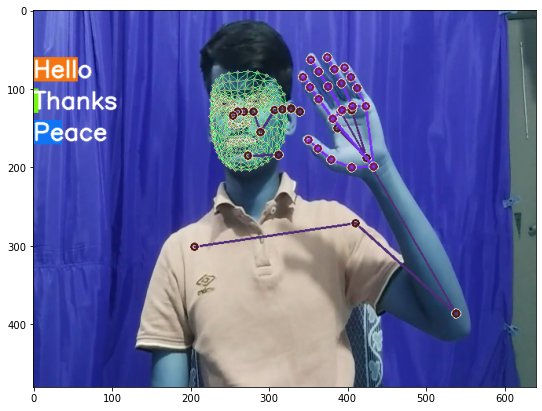

In [56]:
plt.figure(figsize=(9,9))
plt.imshow(prob_viz(res, actions, image, colors))

In [59]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
#         draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

In [54]:
cap.release()
cv2.destroyAllWindows()